# 🌎 Overview

Welcome to the Graph Neural Network tutorial! In this notebook, you will learn how to implement different types of GNN models across an array of different tasks and datasets. Graphs and message passing neural networks lay at the heart of many popular models used today, so we encourage you to read through all of the content carefully. If you have any questions or concerns, please do not hesitante to ask one of the demonstrators. And with that, let's begin! 🏁

**Objectives:**

1.  Understand the basics of GNNs
2.  Implement simple GNN and MLP models using PyTorch and PyTorch Geometric
3.  Train and evaluate your models on node classification and graph regression tasks
4.  Learn about graph visualization, mini-batching, and over-smoothing

Authors: Emily Jin (emily.jin@m2lschool.org) and Mikhail Galkin (mikhail.galkin@m2lschool.org)

Memes created by: Emily Jin

*Based off of a collection of notebooks by Álvaro Arroyo, Federico Barbero, Cristian Bodnar, Iulia Duta, Ben Finkelshtein, Charlie Harris, Emily Jin, Chaitanya K. Joshi, Haitz Sáez de Ocariz Borde, Paul Scherer, and Ramon Viñas Torné.*

<center>
<img src="https://drive.google.com/uc?export=view&id=1S497o4HDVZF303ZJF10zzngW1bGIHMWr" width="500">
</center>

# 🛠️ Section 0: Notebook setup

First, we need to configure this notebook with the correct dependencies. In order to enable GPU acceleration for your notebook, navigate to be done by navigating to `Runtime > Change runtime type > Hardware accelerator > T4 GPU > Save`. If you are unable to get a GPU, this notebook will still work with a CPU, but model training may take longer.

Some other tips & tricks:
- Press `Shift + Enter` to run a cell and move to the next one (`Ctrl + Enter` to only run it)
- When you execute a cell, the variables you create are saved into a global namespace. As a consequence, changes in the code will not take effect until you re-run that specific cell.
- Remember to save your notebook every once in a while!

This notebook relies on the use of PyTorch. Pleases follow the instructions below to ensure the correct version is installed.

In [ ]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.6.0+cu124


In [ ]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign TORCH variable to the value you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.6.0+cu124 # Update this to match the value from the cell above
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-geometric networkx matplotlib

In [ ]:
# @title [Run me] Import python modules

# Let's first import all the things we will need for the first part of this tutorial
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
# from torch_scatter import scatter
from torch_geometric.utils import scatter

from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch_geometric.utils as U
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

import networkx as nx
import numpy as np
import json
import time
from IPython.display import HTML, display, Javascript
import matplotlib.pyplot as plt

# Set your device to GPU on the backend
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 📩 Section 1: Message passing

Before you begin implementing your own GNN, we will first visualize a simple message passing implementation on the Karate Club dataset. In this toy example, each node feature initially contains a feature value of 1.00, and at each subsequent "layer" or iteration, the node features are updated with the sum of the features of all it's neighbors. This mimics the message-passing paradign that most popular GNN models are based on.

Use the slider to see how node colorings (i.e. features) evolve from layer to layer, and hover over a nodes to its exact feature value.
- How does node degree affect the resulting feature values?
- What do you notice about nodes that have similar connectivity?

In [ ]:
# @title [Run me] Interactive visualization

# Load a small graph (Karate Club for simplicity and clarity)
dataset = KarateClub()
data = dataset[0]

# Convert to NetworkX for visualization
G = to_networkx(data, to_undirected=True)

# Simulate node features (e.g., 1D feature per node)
num_nodes = data.num_nodes
features = torch.ones(num_nodes, 1)  # Initial features
history = [features.clone()]  # Store feature history at each hop

# Define a simple message passing: mean of neighbors
edge_index = data.edge_index

def message_passing(x, edge_index):
    out = torch.zeros_like(x)
    # Using scatter_add for efficient message passing
    out = scatter(x[edge_index[0]], edge_index[1], dim=0, dim_size=x.size(0), reduce='sum')
    deg = scatter(torch.ones_like(x[edge_index[0]]), edge_index[1], dim=0, dim_size=x.size(0), reduce='sum')

    deg[deg == 0] = 1  # Avoid division by zero
    return out

# Perform message passing for up to 5 hops
for i in range(5):
    features = message_passing(features, edge_index)
    history.append(features.clone())

# Normalization is removed as per user request, but keeping the function structure
def get_features(x):
    return x

raw_history = [get_features(h).squeeze().tolist() for h in history]


# Build node and edge data for D3.js
nodes = [{'id': i, 'feature': raw_history[0][i]} for i in range(num_nodes)]
edges = [{'source': int(s), 'target': int(t)} for s, t in edge_index.t().tolist()]

# Convert to JSON
graph_json = {
    'nodes': nodes,
    'links': edges,
    'raw_features': raw_history # Raw features for tooltip and coloring
}

# Pass data to JavaScript for rendering
# Correcting the HTML string formatting by using f-string and escaping curly braces
display(HTML(f"""
<style>
.tooltip {{
    position: absolute;
    text-align: center;
    padding: 8px;
    font: 12px sans-serif;
    background: lightsteelblue;
    border: 0px;
    border-radius: 8px;
    pointer-events: none;
    opacity: 0;
    color: black;
}}
</style>
<div id="graph" style="width: 100%; height: 700px;"></div>
<input type="range" min="0" max="5" value="0" id="hopSlider" />
<span id="hopLabel">Layer: 0</span>
<div id="colorbar" style="width: 300px; height: 20px; margin-top: 20px;"></div>
<div class="tooltip"></div>

<script src="https://d3js.org/d3.v7.min.js"></script>
<script>
const graph = {json.dumps(graph_json)};

const width = document.getElementById('graph').clientWidth;
const height = document.getElementById('graph').clientHeight;

const svg = d3.select("#graph")
    .append("svg")
    .attr("width", width)
    .attr("height", height);

// Determine the domain based on raw feature values
let minFeature = d3.min(graph.raw_features.flat());
let maxFeature = d3.max(graph.raw_features.flat());

// interpolateViridis
// interpolateYlGnBu
const colorScale = d3.scaleSequential(d3.interpolateTurbo)
    .domain([minFeature, maxFeature]);


// Define the drag behavior
function drag(simulation) {{
    function dragstarted(event, d) {{
        if (!event.active) simulation.alphaTarget(0.3).restart();
        d.fx = d.x;
        d.fy = d.y;
    }}

    function dragged(event, d) {{
        d.fx = event.x;
        d.fy = event.y;
    }}

    function dragended(event, d) {{
        if (!event.active) simulation.alphaTarget(0);
        d.fx = null;
        d.fy = null;
    }}

    return d3.drag()
        .on("start", dragstarted)
        .on("drag", dragged)
        .on("end", dragended);
}}

// Add Tooltip
const tooltip = d3.select(".tooltip")
    .style("position", "absolute")
    .style("visibility", "hidden");

let simulation = d3.forceSimulation(graph.nodes)
    .force("link", d3.forceLink(graph.links).id(d => d.id).distance(100))
    .force("charge", d3.forceManyBody().strength(-300))
    .force("center", d3.forceCenter(width / 2, height / 2));

let link = svg.append("g")
    .attr("stroke", "#aaa")
    .selectAll("line")
    .data(graph.links)
    .enter().append("line");

let node = svg.append("g")
    .selectAll("circle")
    .data(graph.nodes)
    .enter().append("circle")
    .attr("r", 10)
    .attr("fill", d => colorScale(graph.raw_features[0][d.id])) // Use raw features for initial color
    .call(drag(simulation));

node.append("title")
    .text(d => "Node " + d.id);

// Add hover functionality
node.on("mouseover", function(event, d) {{
    const currentHop = +document.getElementById("hopSlider").value;
    tooltip.style("visibility", "visible")
           .text("Feature value: " + graph.raw_features[currentHop][d.id].toFixed(2)) // Use raw features for tooltip
           .style("top", (event.pageY - 10) + "px")
           .style("left", (event.pageX + 10) + "px")
           .style("opacity", 1);
}})
.on("mousemove", function(event){{
    tooltip.style("top", (event.pageY - 10) + "px").style("left",(event.pageX + 10) + "px");
}})
.on("mouseout", function(){{
    tooltip.style("visibility", "hidden").style("opacity", 0);
}});


simulation.on("tick", () => {{
    link
        .attr("x1", d => d.source.x)
        .attr("y1", d => d.source.y)
        .attr("x2", d => d.target.x)
        .attr("y2", d => d.target.y);

    node
        .attr("cx", d => d.x)
        .attr("cy", d => d.y);
}});

document.getElementById("hopSlider").addEventListener("input", function () {{
    const hop = +this.value;
    document.getElementById("hopLabel").innerText = "Layer: " + hop;
    node.attr("fill", d => colorScale(graph.raw_features[hop][d.id])); // Use raw features for coloring
}});

// Add Color Bar
const colorBarSvg = d3.select("#colorbar")
    .append("svg")
    .attr("width", 300)
    .attr("height", 20);

// Update legend scale based on raw feature domain
const legendScale = d3.scaleLinear()
    .domain([minFeature, maxFeature])
    .range([0, 300]);

colorBarSvg.append("g")
  .selectAll("rect")
  .data(d3.range(minFeature, maxFeature, (maxFeature - minFeature) / 100))
  .enter().append("rect")
    .attr("x", (d) => legendScale(d))
    .attr("y", 0)
    .attr("width", 300 / 100)
    .attr("height", 20)
    .attr("fill", d => colorScale(d));

// Update color bar labels
colorBarSvg.append("text")
    .attr("x", 0)
    .attr("y", 15)
    .text(minFeature.toFixed(2))
    .style("fill", "black");

colorBarSvg.append("text")
    .attr("x", 300)
    .attr("y", 15)
    .text(maxFeature.toFixed(2))
    .style("fill", "black")
    .style("text-anchor", "end");


</script>
"""))

# 📚 Section 2: A GNN for Node Classification

Now, you will implement a basic graph neural network model from scratch **without using PyTorch Geometric**, and prepare it for node classification. You will train your model for node classification on the Cora dataset, which is an academic citation network. The task is to predict the category of each paper, which corresponds to a node in the citation network, among the seven available.

Run the code below to download and visualize the dataset. Note that the different node colorings correspond to the different node classes that your GNN model will try to predict.

In [ ]:
# First, we will download the Cora dataset
dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes

Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


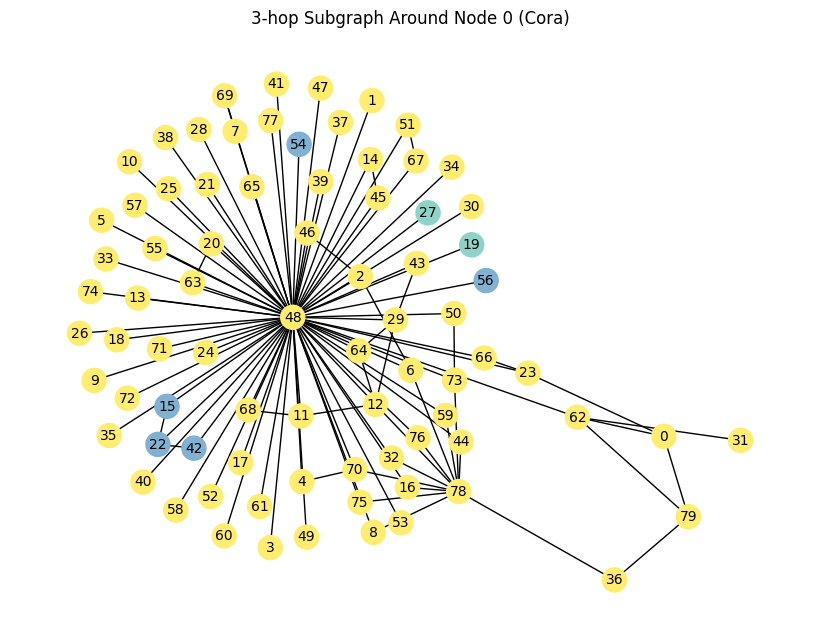

In [ ]:
#@title [Run me] Visualize a subgraph from the Cora dataset

data = dataset[0]

# Convert PyG graph to NetworkX format
G = to_networkx(data, to_undirected=True)

# Sample a subgraph with k-hop neighbors of a single node
from torch_geometric.utils import k_hop_subgraph

# Select a central node (e.g., node 0)
center_node = 0
subset, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx=center_node, num_hops=3, edge_index=data.edge_index, relabel_nodes=True
)

# Convert subgraph to NetworkX
sub_data = data.subgraph(subset)
G_sub = to_networkx(sub_data, to_undirected=True)

# Draw the subgraph
plt.figure(figsize=(8, 6))
nx.draw(G_sub,
        with_labels=True,
        node_size=300,
        node_color=sub_data.y.tolist(),
        cmap=plt.cm.Set3,
        font_size=10)
plt.title("3-hop Subgraph Around Node 0 (Cora)")
plt.show()

### 💻 Task 1: Building a GNN from scratch
To understand the base structure of a PyTorch neural network model `torch.nn.Module`, you will build your GNN as a class with its own instantiation of `__init__` and `forward`. You will define GNN components within `__init__`, and construct the GNN data flow in `forward`. For this task, we will focus on building a simple Graph Convolutional Network (GCN) model.

Be sure to construct your model such that the number of layers is parametrized, so you can increase or decrease the number of layers simply by changing the range of an inner loop that creates the needed layers. Also, your node classification GNN should be composed of a sequence of GCN layers followed by a Multi Layer Perceptron (MLP) head used to classify each node. Therefore, you will define a separate module for each of these components, and then aggregate them together in the final model.

Recall that a `GCNLayer` message passing layer computes the operations as follows:

\begin{equation}
h_i^{(\ell+1)} = \sigma(W_\text{self} h_i^{(\ell)} + W_\text{neigh} \sum_{j \in \text{neigh}(i)} h_j^{(\ell)})
\end{equation}

For the first layer $\ell=0$, $h_i^{\ell=0} = W_{in} \left( h_i \right)$, where $W_{in} \in \mathbb{R}^{d_n}  \rightarrow \mathbb{R}^{d}$ is a simple linear projection (`torch.nn.Linear`) for the initial node features to hidden dimension $d$.

PyTorch is realy efficient in parallelizing computations by vectorizing them. In other words, **do not** loop over all the neighbours of each node to compute the summation in the above equation; you should use instead matrix operations instead.

In [ ]:
# class GCNLayer(nn.Module):

#     def __init__(self, input_dim, output_dim):
#       super().__init__()
#       # YOUR CODE HERE

#     def forward(self, node_feats, adj_matrix):
#       # YOUR CODE HERE

###
# SOLUTION
###
# Be careful that Linear layers are used and no for loop is present in
# the forward function, otherwise the model will be incredibly slow.

class GCNLayer(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Computes the features to feed to itself
        self.w_self = nn.Linear(input_dim,output_dim)

        # Computes the features to feed to neighbours
        self.w_neighbor = nn.Linear(input_dim,output_dim)

    def forward(self, node_feats, adj_matrix):
        # Compute self node features
        self_node_feats = self.w_self(node_feats)

        # Compute neighbor node features
        neighbor_node_feats = self.w_neighbor(node_feats)
        neighbor_node_feats = adj_matrix @ neighbor_node_feats

        # Concatenate self and neighbor features together
        node_feats = self_node_feats + neighbor_node_feats

        return node_feats

The `GNNModule` is a collection of `GCNLayers`. In PyTorch you can create a list of layer by using `nn.ModuleList(layer_1, layer_2, ...)` or, equivalentely `nn.ModuleList(*layer_list)`. Remember activation functions!

In [ ]:
# class GNNModule(nn.Module):

#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        # super().__init__()
#       # YOUR CODE HERE

#     def forward(self, x, adj_matrix):
#       # YOUR CODE HERE

###
# SOLUTION
###

class GNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        super().__init__()

        layers = []
        for _ in range(num_layers-1):
            layers += [
                GCNLayer(input_dim, hidden_dim),
                act_fn(),
            ]
        layers += [GCNLayer(hidden_dim, output_dim)]

        self.layers = nn.ModuleList(layers)

    def forward(self, x, adj_matrix):
        for i, l in enumerate(self.layers):
            if i % 2 == 0:
              x = l(x, adj_matrix)
            else:
              x = l(x)

        return x

The `MLPModule` is a classification head that you apply to each node in the input graph after applying the graph convolutional layers. It is a collection of `nn.Linear` layers.

In [ ]:
# class MLPModule(nn.Module):

#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        # super().__init__()
#       # YOUR CODE HERE

#     def forward(self, x):
#       # YOUR CODE HERE

###
# SOLUTION
###

class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=nn.ReLU):
        super().__init__()
        layers = []
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(input_dim, hidden_dim),
                act_fn(),
            ]
        layers += [nn.Linear(hidden_dim, output_dim)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Now let's aggregate everything in a single class! Note that the `only` parameter indicates whether or not the classifier will use only the GNNModule, only the MLPModule or both. The behavior should be as follows:
- When `only` is False, both the GNNModule and MLPModule are used
- When `only` is set to 'mlp', only the MLPModule is used
- When `only` is set to 'gnn', only the GNNModule is used

In [ ]:
# class CoraNodeClassification(nn.Module):

#     def __init__(
#         self,
#         gnn_input_dim,
#         gnn_hidden_dim,
#         gnn_output_dim,
#         mlp_hidden_dim,
#         mlp_output_dim,
#         gnn_num_layers=2,
#         mlp_num_layers=2,
#         gnn_act_fn=nn.ReLU,
#         mlp_act_fn=nn.ReLU,
#         only = False,
#     ):
        # super().__init__()
#       # YOUR CODE HERE

#     def forward(self, x, adj_matrix):
#       # YOUR CODE HERE

#     # Used to reset the weights of the network when training multiple times with
#     # different hyperparameters
#     def reset_parameters(self):
#         def _reset_module_parameters(module):
#             for layer in module.children():
#                 if hasattr(layer, 'reset_parameters'):
#                     layer.reset_parameters()
#                 elif hasattr(layer, 'children'):
#                     for child_layer in layer.children():
#                         _reset_module_parameters(child_layer)

#         _reset_module_parameters(self)

###
# SOLUTION
###

class CoraNodeClassification(nn.Module):
    def __init__(
        self,
        gnn_input_dim,
        gnn_hidden_dim,
        gnn_output_dim,
        mlp_hidden_dim,
        mlp_output_dim,
        gnn_num_layers=2,
        mlp_num_layers=2,
        gnn_act_fn=nn.ReLU,
        mlp_act_fn=nn.ReLU,
        only = False,
    ):
        super().__init__()
        if only is False:
            self.gnn = GNNModule(gnn_input_dim, gnn_hidden_dim, gnn_output_dim, gnn_num_layers, gnn_act_fn)
            self.mlp = MLPModule(gnn_output_dim, mlp_hidden_dim, mlp_output_dim, mlp_num_layers, mlp_act_fn)
        elif only == 'mlp':
            self.gnn = None
            self.mlp = MLPModule(gnn_input_dim, mlp_hidden_dim, mlp_output_dim, mlp_num_layers, mlp_act_fn)
        elif only == 'gnn':
            self.gnn = GNNModule(gnn_input_dim, gnn_hidden_dim, mlp_output_dim, gnn_num_layers, gnn_act_fn)
            self.mlp = None

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, adj_matrix):
        if self.gnn is not None:
            x = self.gnn(x, adj_matrix)

        if self.mlp is not None:
            x = self.mlp(x)

        return x

    # Used to reset the weights of the network when training multiple times with
    # different hyperparameters
    def reset_parameters(self):
        def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

        _reset_module_parameters(self)

### 💻 Task 2: Train your GNN on node classification
<!-- Create dedicated functions for training and testing. For training, your functions should return a vector containing the train loss and accuracy after each epoch (since Cora contains a single graph one epoch corresponds to one training iteration). You can also print out those values while the training it's running. However, given the large number of epochs, we advise you print every 8 steps or so. Your test function should return the final accuracy on the test set. If everything works correctly you should get around ~75% accuracy. -->
With the model complete, it's time to move on to the fun part - training! Cora uses a masking approach to divide between the train and test sets. Therefore, to compute the loss/accuracy, we mask out the part of the output based on the current settings, e.g., `loss = model.loss_fn(y[data.train_mask], data.y[data.train_mask])`.

In [ ]:
# The Cora dataset contains a single graph of 2708 nodes (i.e., papers).
# We will use some of the nodes as training set and some as test set.
data = dataset[0].to(device)
print(data.x.size())

# According to the GNN equations, we need the adjacency matrix to compute each
# layer convolution. The following line convert the sparse data
# (i.e., list of edges) stored in the dataset in a single dense matrix.
adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)

# Define the hyperparameters we are gonna use:
params = {
    "hidden_features": 128,
    "num_gcn_layers": 2,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 256,
}

# Move the model to the correct device using `.to(device)`
model = CoraNodeClassification(num_features,
                               params["hidden_features"],
                               params["hidden_features"],
                               params["hidden_features"],
                               num_classes,
                               gnn_act_fn=nn.ReLU,
                               mlp_act_fn=nn.ReLU,
                               only=False
  ).to(device)

torch.Size([2708, 1433])


For ease of use, we have provided you with the test and training functions. By testing a randomly initialized module, you should get around ~15% test accuracy.

In [ ]:
def test(model, data, adj_matrix, params):
    model.eval()

    y = model(data.x, adj_matrix)
    correct = (y[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum()
    test_accuracy = int(correct) / int(data.test_mask.sum())

    return test_accuracy

In [ ]:
# Evaluate your randomly initialized model. You should get ~10-15%
test(model, data, adj_matrix, params)

0.111

With training, you should get around ~75-77% test accuracy!


In [ ]:
def train(model, data, adj_matrix, params):
    model.reset_parameters()
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(),
                                lr=params["learning_rate"],
                                weight_decay=params["weight_decay"])
    losses = []
    accuracies = []
    test_accuracies = []

    for e in range(params["num_epochs"] + 1):
        optimizer.zero_grad()
        y = model(data.x, adj_matrix)
        loss = model.loss_fn(y[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        correct = (y[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum()
        train_accuracy = int(correct) / int(data.train_mask.sum())

        losses.append(loss.item())
        accuracies.append(train_accuracy)
        test_accuracy = test(model, data, adj_matrix, params)
        test_accuracies.append(test_accuracy)
        print(f"[Epoch {e}]: Train Accuracy: {train_accuracy} | Test Accuracy: {test_accuracy}")

    return losses, accuracies, test_accuracies

In [ ]:
# Train your node classification model. You should get a final test accuracy of ~75-77%
train_losses, train_accuracies, test_accuracies = train(model, data, adj_matrix, params)
test_accuracy = test(model, data, adj_matrix, params)
print("Final test accuracy:", test_accuracy)

[Epoch 0]: Train Accuracy: 0.15 | Test Accuracy: 0.12
[Epoch 1]: Train Accuracy: 0.17142857142857143 | Test Accuracy: 0.149
[Epoch 2]: Train Accuracy: 0.19285714285714287 | Test Accuracy: 0.226
[Epoch 3]: Train Accuracy: 0.3357142857142857 | Test Accuracy: 0.283
[Epoch 4]: Train Accuracy: 0.42857142857142855 | Test Accuracy: 0.32
[Epoch 5]: Train Accuracy: 0.4928571428571429 | Test Accuracy: 0.348
[Epoch 6]: Train Accuracy: 0.5214285714285715 | Test Accuracy: 0.365
[Epoch 7]: Train Accuracy: 0.5571428571428572 | Test Accuracy: 0.377
[Epoch 8]: Train Accuracy: 0.5642857142857143 | Test Accuracy: 0.39
[Epoch 9]: Train Accuracy: 0.5714285714285714 | Test Accuracy: 0.398
[Epoch 10]: Train Accuracy: 0.5714285714285714 | Test Accuracy: 0.413
[Epoch 11]: Train Accuracy: 0.5857142857142857 | Test Accuracy: 0.42
[Epoch 12]: Train Accuracy: 0.6071428571428571 | Test Accuracy: 0.437
[Epoch 13]: Train Accuracy: 0.6357142857142857 | Test Accuracy: 0.45
[Epoch 14]: Train Accuracy: 0.6571428571428571

By plotting the train accuracy and test accuracy over time, what can you observe?


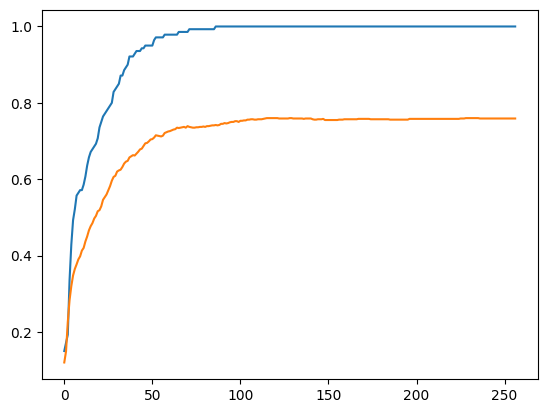

In [ ]:
# Plot train and test accuracies with matplotlib
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.show()

### 💻 Task 3: Importance of GNN and MLP modules
Adjust the `only` parameter in your classifierd so that you only use the GNN or only use the MLP module. What is the impact of the two modules on the final result? Play around with `hidden_features` and `num_layers` a little bit and briefly describe what you observe.

In [ ]:
# YOUR CODE HERE

### 💻 Task 4: Importance of non-linearities
Try replacing all your activation functions with identities (or simply remove them). Do the results change? What does this tell you about this specific problem?

In [ ]:
# YOUR CODE HERE

### 💻 Task 5 [optional]: Improving performance
Try fiddling around with different parts of your model and see if you can boost model performance to above 80%! Some possible options for that would be Dropout and LayerNorm layers.

In [ ]:
# YOUR CODE HERE

# 🧬 Section 3: Exploring molecular data

In the previous section, you trained a GNN for node-level prediction. Now, let's move to a graph-level task to understand **what changes you should make in the architecture**. Here, we will use a molecular dataset, since they are popular benchmarks for graph-level tasks.


<center>
<img src="https://drive.google.com/uc?export=view&id=1P3fZ2IIfEfrbUyuqOrflq46emeFGvu6W" width="500">
</center>



In [ ]:
#@title [Run me] Install dependencies
!pip install -q rdkit
!pip install -q py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 66.0 MB/s eta 0:00:00


In [ ]:
#@title [Run me] Import python modules (Note: if you get an error, you may need to run this cell twice)

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from typing import List

import scipy.linalg
from scipy.linalg import block_diag

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential, Embedding

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import ZINC

import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit import RDLogger
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

# Disable RDKit C++ logging
RDLogger.DisableLog('rdApp.*')

In [ ]:
#@title [Run me] Helper functions for plots and visualization

# ZINC Node labels
atom_labels = {
    0: 'C',
    1: 'O',
    2: 'N',
    3: 'F',
    4: 'C H1',
    5: 'S',
    6: 'Cl',
    7: 'O', #'O -',
    8: 'N', #'N H1 +',
    9: 'Br',
    10: 'N H3 +',
    11: 'N H2 +',
    12: 'N +',
    13: 'N -',
    14: 'S -',
    15: 'I',
    16: 'P',
    17: 'O H1 +',
    18: 'N H1 -',
    19: 'O +',
    20: 'S +',
    21: 'P H1',
    22: 'P H2',
    23: 'C H2 -',
    24: 'P +',
    25: 'S H1 +',
    26: 'C H1 -',
    27: 'P H1 +'
}

# ZINC Edge labels
bond_labels = {
    1: 'SINGLE',
    2: 'DOUBLE',
    3: 'TRIPLE'
}

def pyg_data_to_mol(data):
    mol = Chem.RWMol()

    # Add atoms
    for x in data.x.squeeze().tolist():  # z contains atomic numbers
        atom_num = int(x)
        mol.AddAtom(Chem.Atom(atom_labels[x]))

    # Add bonds
    edge_index = data.edge_index
    edge_attr = data.edge_attr  # bond type
    num_edges = edge_index.size(1)

    for i in range(0, num_edges):  # edges are duplicated in PyG (both directions)
        start = edge_index[0, i].item()
        end = edge_index[1, i].item()
        bond_type_val = int(edge_attr[i].item())

        if bond_type_val == 1:
            bond_type = Chem.BondType.SINGLE
        elif bond_type_val == 2:
            bond_type = Chem.BondType.DOUBLE
        elif bond_type_val == 3:
            bond_type = Chem.BondType.TRIPLE
        else:
            bond_type = Chem.BondType.SINGLE  # default

        try:
            mol.AddBond(start, end, bond_type)
        except:
            pass
            # print(f"Error adding bond between {start} and {end}")
        # mol.AddBond(start, end, bond_type)

    return mol.GetMol()

def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

####### GRAPH VISUALISATIONS #######

class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure
            for a mini-batch it will store a big (sparse) graph
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index,
                              # we work with a binary adj containing 1 if an edge exist
                              torch.ones((self.edge_index.shape[1])),
                              torch.Size((self.num_nodes, self.num_nodes))
                              )

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

def hash_node_embedings(node_emb):
  """ Hash the tensor representing nodes' features
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes)
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

  node_emb_flatten = np.concatenate(node_emb).mean(-1)

  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb)

  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed

####### PLOTS #######

def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats

def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))

def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))

## ZINC Dataset

[ZINC](https://arxiv.org/abs/1610.02415) is a dataset for graph-regression that contains 12,000 molecular graphs with up to 38 nodes each. Node features denote atom type, edge features denote bond type, and the task is to predict the constrained solubility (a scalar number) for each molecule. Let's load it in from [torch_geometric.dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.ZINC) and see what it contains:

In [ ]:
# Download ZINC dataset from PyG
train_zinc_dataset = ZINC(root='', split='train', subset=True)
val_zinc_dataset = ZINC(root='', split='val', subset=True)
test_zinc_dataset = ZINC(root='', split='test', subset=True)

print(f"\nTrain examples: {len(train_zinc_dataset)}")
print(f"Val examples: {len(val_zinc_dataset)}")
print(f"Test examples: {len(test_zinc_dataset)}\n")

one_graph = train_zinc_dataset[0]

print(f"First graph contains {one_graph.x.shape[0]} nodes, each characterised by {one_graph.x.shape[1]} features")
print(f"Graph labels have shape: {one_graph.y.shape}")

Extracting ./molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 8219.85it/s]


Train examples: 10000
Val examples: 1000
Test examples: 1000

First graph contains 29 nodes, each characterised by 1 features
Graph labels have shape: torch.Size([1])



Done!


Each molecular graph is stored as a [torch_geometric.Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object. The node features `x` denote atom type and have the shape `[num_nodes, 1]`, and the edge features `edge_attr` denote bond type. Note that instead of storing an entire adjacency matrix to describe the graph structure, edges are stored more efficiently in a `edge_index`, which is as a list of edges of shape `[2, num_edges]`. Here, `y` contains the molecule's constrained solubility value, which your GNN try to will predict.

In [ ]:
print(one_graph)

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])


Now, let's visualize the molecular graph using the `networkx` library.

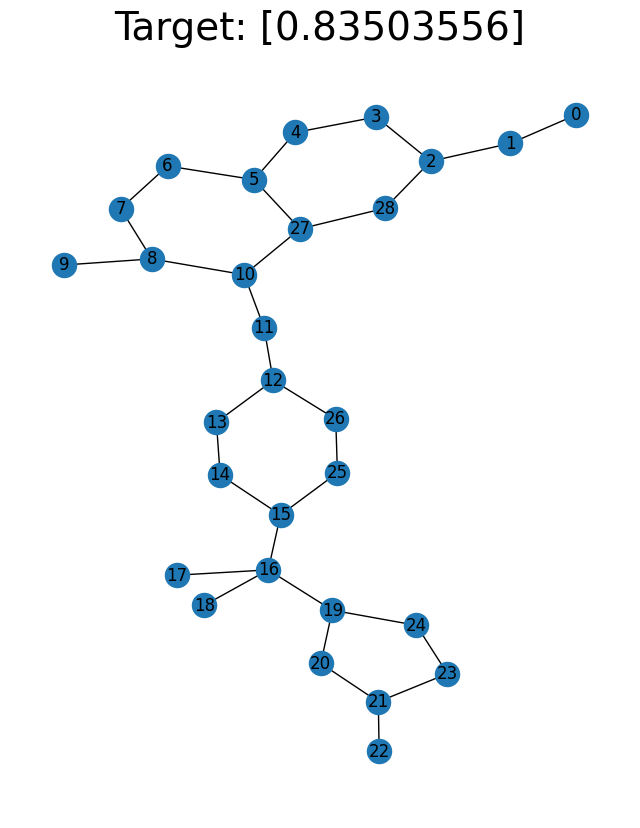

In [ ]:
# Visualize molecular graph with networkx function pre-defined above
gallery([one_graph], labels=np.array([one_graph.y]), max_fig_size=(8,10))

Next, we will use RDKit to get a more representative view of the molecules in this dataset:

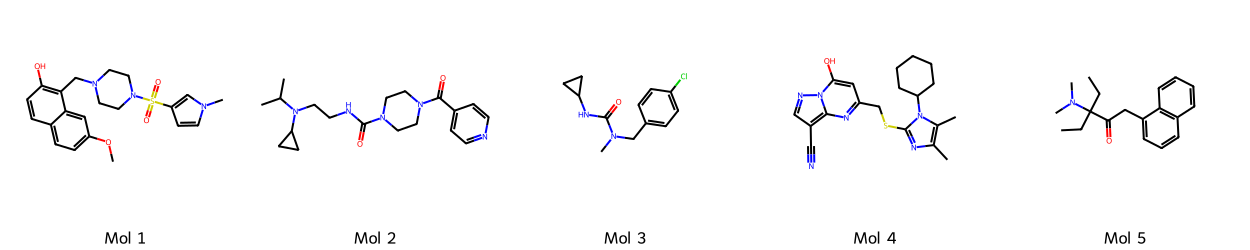

In [ ]:
# Molecular visualization with RDKit, showing the first 5 graphs in the ZINC dataset
mols_list = []
for i in range(5):
  mol = pyg_data_to_mol(train_zinc_dataset[i])
  Chem.SanitizeMol(mol)
  mols_list.append(mol)

img = Draw.MolsToGridImage(
    mols_list,
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=[f"Mol {i+1}" for i in range(len(mols_list))]
)
img

To get a more interactive feel for each molecular graph, we can also visualize it in 3D with py3Dmol. Try rotating the molecule around and zooming in and out to get a better sense of its geometry:

In [ ]:
# 3D molecular visualization
mol = pyg_data_to_mol(train_zinc_dataset[0])
Chem.SanitizeMol(mol)
viewer = MolTo3DView(mol)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# 👯 Section 4: Mini-batching for graph data

Since we are now dealing with multiple graphs, we need to figure out how to store them in mini-batches to be able to make the computation as efficient as possible. For some types of data, stacking samples in mini-batches is a trivial task. For example, images of $32\times32$ pixels are easy to batch because they have the same dimension (obtaining a tensor of dimension $batch\_{size}\times32\times32$). On the other hand, graphs come in different sizes with adjacency matrices of different shapes:

In [ ]:
print(f'First graph : {train_zinc_dataset[0].x.shape} with adjacency {(train_zinc_dataset[0].num_nodes, train_zinc_dataset[0].num_nodes)}')
print(f'Second graph: {train_zinc_dataset[1].x.shape} with adjacency {(train_zinc_dataset[1].num_nodes, train_zinc_dataset[1].num_nodes)}')
print(f'Third graph : {train_zinc_dataset[2].x.shape} with adjacency {(train_zinc_dataset[2].num_nodes, train_zinc_dataset[2].num_nodes)}')

First graph : torch.Size([29, 1]) with adjacency (29, 29)
Second graph: torch.Size([26, 1]) with adjacency (26, 26)
Third graph : torch.Size([16, 1]) with adjacency (16, 16)


One solution for this is to create a single *sparse* graph as the union of all the graphs in the mini-batch as follow:

1. stack the features $x$ for all the nodes in all the graphs
2. stack the labels $y$ for all the nodes in all the graphs
3. stack all the adjacency matrices $A_i$ as diagonal blocks in the new adjacency matrix

This way, we will obtain a new graph containing $\sum_{i=1}^{B}|V_i|$ nodes, where $B$ is the batch_size and by $|V_i|$ we denote the number of nodes in graph $i$. Note that since **no** edges connect nodes from different graphs,  the  information propagation will not be affected by the way we store it.  

<center>
<img src="https://drive.google.com/uc?export=view&id=1RwI0CYA57S0OgLxgHgV6PBFNG9tnGvGR" width="500">
</center>

<center>
<img src="https://drive.google.com/uc?export=view&id=1Ux65wTJLXCfJ4TI4Up4mCHkaSja8NgrJ" width="500">
</center>

As you can see, the resulting matrix contains many zeros (sparse), thus our choice of storing the adjacency matrix as a sparse tensor can indeed bring us efficiency.

Until now, we have a way to store the graphs in a mini-batch such that they could be efficiently processed.

However, we need to also be able to extract information from this structure, to recover the graphs that it contains. For this, we need to remember what initial graph each node belongs to.

We will do this by storing a list of indices `(self.batch)`, which map each node in the batch-graph to the initial graph it belong to. For example `batch=[0,0,0,1,1,2,2,2]` indicates that first 3 nodes belong to $G_0$, the next 2 nodes belong to $G_1$ and the last 3 nodes belong to $G_2$.



In [ ]:
def create_mini_batch(graph_list: List[Graph]) -> Graph:
    """ Built a sparse graph from a batch of graphs
    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    #insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)

    nodes_count = graph_list[0].num_nodes

    #append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):
        # concat the features
        batch_x = torch.cat((batch_x, graph.x))
        # concat the labels
        batch_y = torch.cat((batch_y, graph.y))

        # concat the adjacency matrix as a block diagonal matrix

        # here we have to modify the current graph edge index by adding
        # to the row and column the number of nodes we have already
        # added to the batch, this way when computing the sparse block matrix,
        # we position the nodes correctly
        batch_edge_index = torch.cat((
            batch_edge_index,
            torch.add(graph.edge_index, nodes_count))
        , dim=1)
        nodes_count += graph.num_nodes

        # create the array of indexes mapping nodes in the batch-graph
        # to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)

        # here we append a vector of [idx+1, idx+1,...] which has dimension graph.num_nodes
        # to our existing batch_batch vector to keep track of the nodes
        batch_batch = torch.cat((
            batch_batch,
            torch.full((graph.num_nodes,), idx + 1)
        ))

    #create the big sparse graph
    batch_graph = Graph(batch_edge_index, batch_x, batch_y)
    #attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)
    return batch_graph

Batch number_of_nodes: 12
Batch features shape: torch.Size([12, 32])
Batch labels shape: torch.Size([3])
Batch adjacency: 
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 1 0 1 1 1 0 0 0 0
0 0 0 1 0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 0 1 0 0 0


/tmp/ipython-input-445121820.py:137: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  return torch.sparse.LongTensor(self.edge_index,


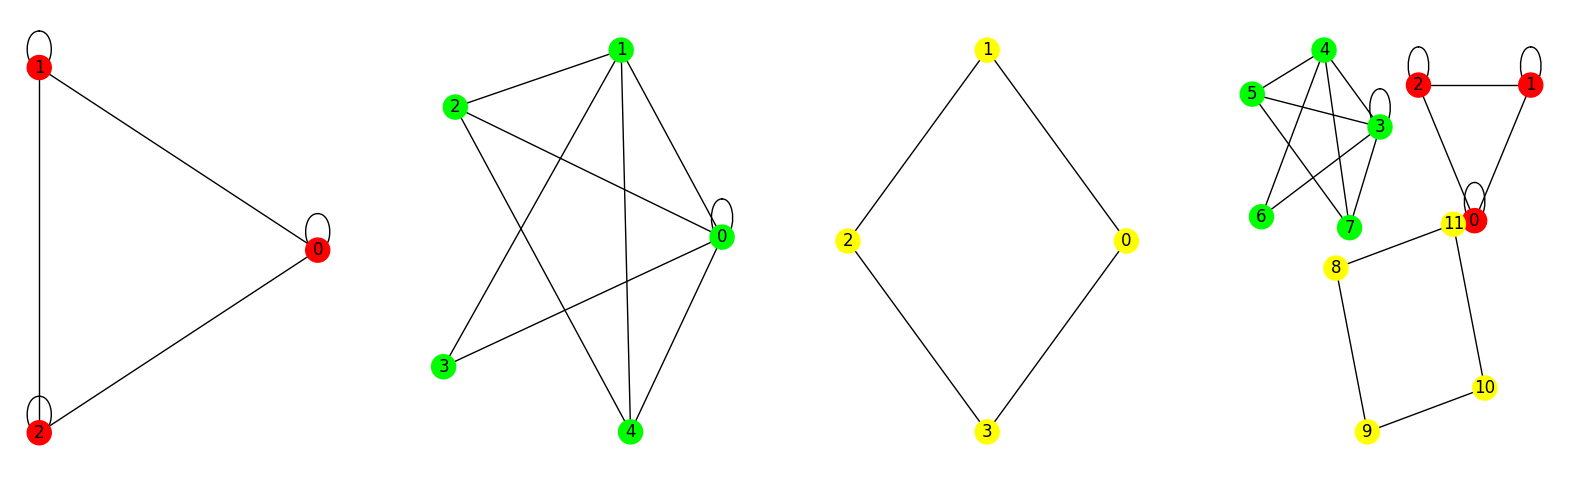

Also, we have access to which graph each node belongs to: tensor([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2])



In [ ]:
#@title [Run me] Visualize the mini-batching for a small list of batch_size=3 graphs

# 3 random custom-designed graphs for visualisations
graph1 = Graph(x=torch.rand((3,32)),
               y=torch.rand((1)),
               edge_index=torch.tensor([[0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]]))
graph2 = Graph(x=torch.rand((5,32)),
               y=torch.rand((1)),
               edge_index=torch.tensor([[0,0,0,0,0,1,1,1,2,1,2,3,4], [0,1,2,3,4,2,3,4,4,0,0,0,0]]))
graph3 = Graph(x=torch.rand((4,32)),
               y=torch.rand((1)),
              edge_index=torch.tensor([[0,1,2,3],[1,2,3,0]]))
list_graphs = [graph1, graph2, graph3]

# create a mini-batch from these 3 graphs
batch_sample = create_mini_batch(list_graphs)

# show statistics about the new graph built from this batch of graphs
print(f"Batch number_of_nodes: {batch_sample.num_nodes}")
print(f"Batch features shape: {batch_sample.x.shape}")
print(f"Batch labels shape: {batch_sample.y.shape}")

print(f"Batch adjacency: ")
print_color_numpy(batch_sample.get_adjacency_matrix().to_dense().numpy(), list_graphs)

gallery([graph1, graph2, graph3, batch_sample], max_fig_size=(20,6), special_color=True)
print(f"Also, we have access to which graph each node belongs to: {batch_sample.batch}\n")


As we can see, the adjacency matrix above is in a *block diagonal* structure. With this structure, effectively each graph is independent from the other - exactly what we want for batching! We would not want the representations of a graph to affect the representation of a different graph.

When training our model, manually implementing this batching process can get quite arduous. Fortunately, we can rely on the `DataLoader` [module](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) from PyTorch to handle the batching for us!

In [ ]:
# Create dataloaders with batch size = 128
train_loader = DataLoader(train_zinc_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_zinc_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_zinc_dataset, batch_size=128, shuffle=False)

# 🕸️ Section 5: Graph Regression with GIN

Now, we will design a  Graph Neural Network model, similar to the one used on Cora, with the following modifications:
* graph-level prediction instead of node-level prediction
* regression instead of classification
* to obtain a *provablly more powerful architecture*, we will go beyond a GCN Layer and implement a [Graph Isomorphism Network (**GIN**)](https://arxiv.org/abs/1810.00826)

One simple instantiation of GIN Layer processes the graph according to the following message passing equation, where $\epsilon_k$ is a learnable scalar

\begin{equation}
X^{k+1}= \text{MLP}_k\big(AX^k + (1+\epsilon_k)X^k\big)
\end{equation}


### 💻 **Task 6:** Implement GIN using PyTorch Geometric

Since you've already implemented message passing the hard way in the section above, you will build your model using PyTorch Geometric modules this time. Some functions that may come in handy include:
- `torch.nn.Embedding` ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html)) to embed the inital atom input features
- `torch_geometric.nn.GINConv` ([documentation](https://pytorch-geometric.readthedocs.io/en/2.5.1/generated/torch_geometric.nn.conv.GINConv.html))
- `torch_geometric.nn.models.MLP` ([documentation](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.models.MLP.html))
- `squeeze()` ([documentation](https://docs.pytorch.org/docs/stable/generated/torch.squeeze.html)) to adjust the dimensions of your features

Also, remember that you are performing a graph-level regression task this time! To obtain a graph-level representation, you will need to pool the individual node representations together at the end with the torch `scatter` [function](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html). For now, you can ignore the `residual` parameter; this will come into play later on. And again, don't forget your activation functions!

In [ ]:
# class GINRegression(nn.Module):
#     def __init__(self, num_layers, input_dim, emb_dim, residual):
#         super().__init__()
#         # YOUR CODE HERE

#     def forward(self, data):
#         # YOUR CODE HERE

###
# SOLUTION
###

from torch_geometric.nn.models import MLP
from torch_geometric.nn.conv import GINConv

class GINRegression(nn.Module):
    def __init__(
        self,
        num_layers=5,
        input_dim=28,  # if categorical indices present, provide this
        emb_dim=64,
        residual=False
    ):
        super().__init__()
        self.num_layers = num_layers
        self.emb_dim = emb_dim
        self.residual = residual

        # First generate atom embeddings
        self.embed = nn.Embedding(input_dim, emb_dim, padding_idx=None)

        # Build GIN layers
        self.convs = nn.ModuleList()
        for layer in range(num_layers):
            mlp = MLP(in_channels=emb_dim, hidden_channels=emb_dim, out_channels=emb_dim, num_layers=2)
            conv = GINConv(mlp)
            self.convs.append(conv)

        self.predictor = MLP(in_channels=emb_dim, hidden_channels=emb_dim, out_channels=1, num_layers=2)

    def forward(self, data):
        # x is shape [N,1] -> squeeze to [N]
        x = data.x
        x_idx = x.squeeze()

        # run embedding on categorical / 1-hot + Linear
        x = self.embed(x_idx)

        # GIN layers
        for conv in self.convs:
            x_in = x
            x = conv(x, data.edge_index)
            x = F.relu(x)

            # residual connections
            if self.residual:
                x = x + x_in

        # global pooling
        g = scatter(x, data.batch)  # [num_graphs, emb_dim]

        out = self.predictor(g).squeeze(-1)  # [num_graphs]
        return out

## 💻 Task 7: Train your GNN on graph regression

In [ ]:
# Here we define training and evaluation functions. We will track L1 loss, which
# corresponds to mean absolute error (MAE) for regression
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)

        loss = F.l1_loss(pred, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return (total_loss / len(loader))

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        pred = model(data)
        loss = F.l1_loss(pred, data.y)
        total_loss += loss.item()
    return (total_loss / len(loader))

def run_experiment(model):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epochs = 20
    for epoch in range(1, epochs + 1):
      train_mae = train(model, train_loader, optimizer, device)
      val_mae = evaluate(model, val_loader, device)
      print(f"[Epoch {epoch}] | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

    test_mae = evaluate(model, test_loader, device)
    print("Final test MAE: {:.4f}".format(test_mae))

In [ ]:
# Run GINRegression on graph regression task
model = GINRegression(
    num_layers=4,
    input_dim=28,
    emb_dim=64,
    residual=False
).to(device)
run_experiment(model)

[Epoch 1] | Train MAE: 0.6993 | Val MAE: 0.7089
[Epoch 2] | Train MAE: 0.5505 | Val MAE: 0.5282
[Epoch 3] | Train MAE: 0.5140 | Val MAE: 0.5760
[Epoch 4] | Train MAE: 0.4942 | Val MAE: 0.5198
[Epoch 5] | Train MAE: 0.4934 | Val MAE: 0.5449
[Epoch 6] | Train MAE: 0.4770 | Val MAE: 0.5952
[Epoch 7] | Train MAE: 0.4642 | Val MAE: 0.5892
[Epoch 8] | Train MAE: 0.4701 | Val MAE: 0.4586
[Epoch 9] | Train MAE: 0.4500 | Val MAE: 0.4377
[Epoch 10] | Train MAE: 0.4544 | Val MAE: 0.6703
[Epoch 11] | Train MAE: 0.4652 | Val MAE: 0.4417
[Epoch 12] | Train MAE: 0.4432 | Val MAE: 0.4483
[Epoch 13] | Train MAE: 0.4404 | Val MAE: 0.5753
[Epoch 14] | Train MAE: 0.4339 | Val MAE: 0.5741
[Epoch 15] | Train MAE: 0.4258 | Val MAE: 0.4940
[Epoch 16] | Train MAE: 0.4250 | Val MAE: 0.5138
[Epoch 17] | Train MAE: 0.4254 | Val MAE: 0.4355
[Epoch 18] | Train MAE: 0.4142 | Val MAE: 0.4425
[Epoch 19] | Train MAE: 0.4129 | Val MAE: 0.4263
[Epoch 20] | Train MAE: 0.3949 | Val MAE: 0.4369
Final test MAE: 0.4520


Now try runinng your model with more layers. How does the performance change?

In [ ]:
deep_model = GINRegression(
    num_layers=16,
    input_dim=28,
    emb_dim=64,
    residual=False
).to(device)
run_experiment(deep_model)

[Epoch 1] | Train MAE: 0.9712 | Val MAE: 1.2041
[Epoch 2] | Train MAE: 0.6587 | Val MAE: 0.7036
[Epoch 3] | Train MAE: 0.5923 | Val MAE: 0.6212
[Epoch 4] | Train MAE: 0.5782 | Val MAE: 0.5635
[Epoch 5] | Train MAE: 0.5467 | Val MAE: 0.6940
[Epoch 6] | Train MAE: 0.5328 | Val MAE: 0.5088
[Epoch 7] | Train MAE: 0.5193 | Val MAE: 0.5189
[Epoch 8] | Train MAE: 0.5079 | Val MAE: 0.5653
[Epoch 9] | Train MAE: 0.4981 | Val MAE: 0.4827
[Epoch 10] | Train MAE: 0.4833 | Val MAE: 0.5030
[Epoch 11] | Train MAE: 0.4914 | Val MAE: 0.4887
[Epoch 12] | Train MAE: 0.4913 | Val MAE: 0.5727
[Epoch 13] | Train MAE: 0.4727 | Val MAE: 0.5517
[Epoch 14] | Train MAE: 0.4835 | Val MAE: 0.5107
[Epoch 15] | Train MAE: 0.4704 | Val MAE: 0.5756
[Epoch 16] | Train MAE: 0.4697 | Val MAE: 0.4946
[Epoch 17] | Train MAE: 0.4515 | Val MAE: 0.5952
[Epoch 18] | Train MAE: 0.4550 | Val MAE: 0.5020
[Epoch 19] | Train MAE: 0.4419 | Val MAE: 0.5313
[Epoch 20] | Train MAE: 0.4541 | Val MAE: 0.4602
Final test MAE: 0.4799


## 💻 Task 8: Adding residual connections

The phenomenon you witnessed above is called *over-smoothing*, which is when node-representations become indistinguishable from each other as the number of network layers increases.

The full GIN architecture as introduced in the original [paper](https://arxiv.org/pdf/1810.00826.pdf), does not use only the final output for predictions. Instead, it creates a graph representation from the representation of all the intermediate layers:

\begin{equation}
h_G = CONCAT\big(\oplus_{v \in G}\{h_v^{(k)}\}| k=0,1..(K-1) \big)
\end{equation}

where $\oplus_{v \in G}\{h_v^{(k)}\}$ represents the graph-level representations at layer $k$, obtained by summing the representations from all the nodes $v \in G$. These are also referred to as *residual connections*, and have been shown to help combat the effects of over-smoothing.

Adjust your `GINRegression` model to incorporate residual connections, and re-run training and evaluation.

In [ ]:
deep_residual_model = GINRegression(
    num_layers=16,
    input_dim=28,
    emb_dim=64,
    residual=True
).to(device)
run_experiment(deep_residual_model)

[Epoch 1] | Train MAE: 0.6876 | Val MAE: 1.1633
[Epoch 2] | Train MAE: 0.5178 | Val MAE: 0.5912
[Epoch 3] | Train MAE: 0.4923 | Val MAE: 2.9789
[Epoch 4] | Train MAE: 0.4762 | Val MAE: 0.4918
[Epoch 5] | Train MAE: 0.4604 | Val MAE: 0.6155
[Epoch 6] | Train MAE: 0.4587 | Val MAE: 0.6464
[Epoch 7] | Train MAE: 0.4508 | Val MAE: 0.5071
[Epoch 8] | Train MAE: 0.4264 | Val MAE: 0.6312
[Epoch 9] | Train MAE: 0.4323 | Val MAE: 0.5319
[Epoch 10] | Train MAE: 0.4260 | Val MAE: 0.4770
[Epoch 11] | Train MAE: 0.4242 | Val MAE: 0.4235
[Epoch 12] | Train MAE: 0.4210 | Val MAE: 0.5687
[Epoch 13] | Train MAE: 0.4126 | Val MAE: 0.5295
[Epoch 14] | Train MAE: 0.4070 | Val MAE: 0.4247
[Epoch 15] | Train MAE: 0.4012 | Val MAE: 0.5133
[Epoch 16] | Train MAE: 0.3909 | Val MAE: 0.4530
[Epoch 17] | Train MAE: 0.3848 | Val MAE: 0.4611
[Epoch 18] | Train MAE: 0.4122 | Val MAE: 0.6682
[Epoch 19] | Train MAE: 0.3901 | Val MAE: 0.4563
[Epoch 20] | Train MAE: 0.3806 | Val MAE: 0.4203
Final test MAE: 0.4167


## 💻 Task 9 [optional]: Adding edge features

Notice that we did not use edge features (i.e. bond information) when computing the graph-level representations, which may help improve our molecular embeddings. Modify your `GINRegression` model to incorporate this edge information, and see how the performance changes. You may find the `torch_geometric.nn.conv.GINEConv` ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINEConv.html)) function helpful.

In [ ]:
# YOUR CODE HERE

# 🎉   Kraj

That's all for today! We hope now you've learned to love graphs as much as we do ❤️

<center>
<img src="https://drive.google.com/uc?export=view&id=1A-a1YWc6c8ZWFV_4gblsnVi85S8sBRuv" width="500">
</center>